# This notebook validates trained BuDDI4 models on whether the sample id latnet space informs decoding and is sufficiently disentangled from the other latent spaces, for the bulk RNA-seq data

In [1]:
import joblib
import sys
import pathlib
import yaml
import subprocess

import numpy as np
import pandas as pd
import tensorflow as tf

2025-05-20 15:13:24.432763: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 15:13:24.443028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747775604.453493 3178414 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747775604.456661 3178414 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747775604.465878 3178414 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
CELL_TYPE_COL = 'encode_celltype'
SAMPLE_ID_COL = 'sample_id'
STIM_COL = 'stim'
TECH_COL = 'samp_type'
DATASPLIT_COL = 'isTraining'

GENE_ID_COL = 'gene_ids'

In [3]:
# Get the root directory of the analysis repository
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)

CONFIG_FILE = REPO_ROOT / 'config.yml'
assert CONFIG_FILE.exists(), f"Config file not found at {CONFIG_FILE}"

with open(CONFIG_FILE, 'r') as file:
    config_dict = yaml.safe_load(file)

### Get HGSC subtype calls and format

In [4]:
data_path = pathlib.Path(config_dict['data_path']['bulk_data_path'])

bulk_metadata_files = [
    'supp_table_3_main_black_metadata_table.tsv',
    'supp_table_4_main_white_metadata_table.tsv'
]

bulk_metadata_df = pd.DataFrame()
for file in bulk_metadata_files:
    file_path = data_path / file
    if file_path.exists():
        temp_df = pd.read_csv(file_path, sep='\t')
        if 'white' in str(file):
            temp_df['race'] = 'white'
        elif 'black' in str(file): 
            temp_df['race'] = 'black'
        else:
            temp_df['race'] = 'unknown'
        
        bulk_metadata_df = pd.concat([bulk_metadata_df, temp_df], ignore_index=True)
    else:
        print(f"File not found: {file_path}")

bulk_metadata_df = bulk_metadata_df.drop_duplicates(subset='ID')
bulk_metadata_df[SAMPLE_ID_COL] = bulk_metadata_df['ID']
bulk_metadata_df.set_index('ID', inplace=True)
bulk_metadata_df.head()

ran_in_way_pipeline  ClusterK2_kmeans  ClusterK3_kmeans  \
ID                                                                
19291X1                True               1.0               1.0   
19291X2                True               1.0               1.0   
18341X1                 NaN               NaN               NaN   
19291X3                True               2.0               2.0   
19291X4                True               1.0               1.0   

         ClusterK4_kmeans  ClusterK2_NMF  ClusterK3_NMF  ClusterK4_NMF  \
ID                                                                       
19291X1               1.0            1.0            1.0            1.0   
19291X2               1.0            1.0            1.0            1.0   
18341X1               NaN            NaN            NaN            NaN   
19291X3               2.0            1.0            2.0            2.0   
19291X4               1.0            1.0            2.0            2.0   

        ClusterK4_kmeans_TCGA_names external_HGSCsubtype_estimate  failed_seq  \
ID                                                                              
19291X1                 Mesenchymal                           NaN         NaN   
19291X2                 Mesenchymal                           NaN         NaN   
18341X1                         NaN                        C4.DIF         NaN   
19291X3               Proliferative                           NaN         NaN   
19291X4                 Mesenchymal                           NaN         NaN   

         ... low_qual   version REMOVE_WHITE REMOVE_NEOADJ  \
ID       ...                                                 
19291X1  ...      NaN  full_run          NaN           NaN   
19291X2  ...      NaN  full_run          NaN           NaN   
18341X1  ...      NaN     pilot         True           NaN   
19291X3  ...      NaN  full_run          NaN           NaN   
19291X4  ...      NaN  full_run          NaN           NaN   

        REMOVE_LOW_EXPRESSION study Sample_ID   race REMOVE_BLACK sample_id  
ID                                                                           
19291X1                   NaN    AA   NCO0003  black          NaN   19291X1  
19291X2                   NaN    AA   NCO0028  black          NaN   19291X2  
18341X1                   NaN    AA   NCO0051  black          NaN   18341X1  
19291X3                   NaN    AA   NCO0076  black          NaN   19291X3  
19291X4                   NaN    AA   NCO0080  black          NaN   19291X4  

[5 rows x 21 columns]

In [5]:
#  rename external HGSC subtype columns
subtype_mapping = {
    'C4.DIF': 'Differentiated',
    'C2.IMM': 'Immunoreactive',
    'C1.MES': 'Mesenchymal',
    'C5.PRO': 'Proliferative'
}

bulk_metadata_df['subtype_label'] = bulk_metadata_df['external_HGSCsubtype_estimate'].map(
    subtype_mapping)

# combine with internal calls
mask = bulk_metadata_df['ClusterK4_kmeans_TCGA_names'].notna()
bulk_metadata_df.loc[mask, 'subtype_label'] = bulk_metadata_df.loc[mask, 'ClusterK4_kmeans_TCGA_names']

# metadata for origin of subtype label
bulk_metadata_df['subtype_label_source'] = 'internal'
bulk_metadata_df.loc[mask, 'subtype_label_source'] = 'external'

In [6]:
pd.crosstab(bulk_metadata_df['race'], bulk_metadata_df['subtype_label'])

subtype_label  Differentiated  Immunoreactive  Mesenchymal  Proliferative
race                                                                     
black                      27             107           86             66
white                      77              76           98             35

## Software

In [7]:
buddi_fork_path = config_dict['software_path']['buddi_v2']
buddi_fork_path = pathlib.Path(buddi_fork_path)
assert buddi_fork_path.exists(), f"buddi fork not found at {buddi_fork_path}"

sys.path.append(str(REPO_ROOT))
sys.path.append(str(buddi_fork_path))
# this is quite ugly, once activate modifications are done this will be changed
# to a proper installation + import
from buddi_v2.models.buddi4_class import BuDDI4

## Define paths to Input Files/Output

### Input from pre-processing

In [8]:
PREPROCESSING_OUTPUT_PATH = REPO_ROOT / 'processed_data' 
buddi4_data_file = PREPROCESSING_OUTPUT_PATH / 'buddi4_data.pkl'
assert buddi4_data_file.exists(), f"Train data file not found at {buddi4_data_file}"

### Trained model save path

In [9]:
TRAINED_MODELS_PATH = REPO_ROOT / 'trained'
model_folders = sorted(TRAINED_MODELS_PATH.glob('buddi4_*'))
assert len(model_folders) > 0, f"No trained models found in {TRAINED_MODELS_PATH}"

In [10]:
filtered_model_folders = [
    folder for folder in model_folders if 'label_beta=10.0;' in str(folder)
]
[
    folder.parts[-1] for folder in filtered_model_folders
]

['buddi4_1db615ec;beta=1.0;label_beta=10.0;slack_beta=0.1',
 'buddi4_20b78de8;beta=100.0;label_beta=10.0;slack_beta=0.1',
 'buddi4_245f68d4;beta=1.0;label_beta=10.0;slack_beta=1.0',
 'buddi4_5d9bd07f;beta=10.0;label_beta=10.0;slack_beta=0.1',
 'buddi4_5eb8e613;beta=10.0;label_beta=10.0;slack_beta=1.0',
 'buddi4_804726e7;beta=100.0;label_beta=10.0;slack_beta=1.0',
 'buddi4_a5f47abc;beta=10.0;label_beta=10.0;slack_beta=1.0',
 'buddi4_b02e1758;beta=1.0;label_beta=10.0;slack_beta=0.1',
 'buddi4_b21d49ef;beta=1.0;label_beta=10.0;slack_beta=1.0',
 'buddi4_dd77cdd8;beta=100.0;label_beta=10.0;slack_beta=0.1',
 'buddi4_e4ce5b46;beta=100.0;label_beta=10.0;slack_beta=1.0',
 'buddi4_e6bc090b;beta=10.0;label_beta=10.0;slack_beta=0.1']

## Load Data

In [11]:
buddi4_data = joblib.load(buddi4_data_file)
print(buddi4_data)
print('\n')

n_x = len(buddi4_data.gene_names)
n_y = len(buddi4_data.cell_type_names)
n_labels = buddi4_data.encode_meta[SAMPLE_ID_COL].shape[1]
n_stims = buddi4_data.encode_meta[STIM_COL].shape[1]
n_samp_types = buddi4_data.encode_meta[TECH_COL].shape[1]
print(f"Number of genes: {n_x}")
print(f"Number of cell types: {n_y}")
print(f"Number of unique labels: {n_labels}")
print(f"Number of unique stimulations: {n_stims}")
print(f"Number of unique sample types: {n_samp_types}")

BuDDI4Data(total_samples=8988, genes=7000, cell_types=11)


Number of genes: 7000
Number of cell types: 11
Number of unique labels: 593
Number of unique stimulations: 2
Number of unique sample types: 2


In [12]:
print(filtered_model_folders[0].parts[-1])
print('\n')

obj = BuDDI4.load(
    filtered_model_folders[0] 
)
print(obj.encoders)
print(obj.decoder)
print(obj.prop_estimator)

buddi4_1db615ec;beta=1.0;label_beta=10.0;slack_beta=0.1




I0000 00:00:1747775608.089340 3178414 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4292 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


{'label': <Functional name=encoder_label, built=True>, 'stim': <Functional name=encoder_stim, built=True>, 'samp_type': <Functional name=encoder_samp_type, built=True>, 'slack': <Functional name=encoder_slack, built=True>}
<Functional name=shared_X_decoder, built=True>
<Functional name=prop_estimator, built=True>


In [13]:
from analysis_utils.inference.inference import _impute_sc_expression
from analysis_utils.plot_reconstruction import plot_reconstruction

In [14]:
X, meta = buddi4_data.query(
    isTraining='Train',
    samp_type='bulk',
    stim='black',
).get(
    ('X', 'meta'),
    n_samples=40,
    replace=False,
    random_state=42
)
meta.head()

sample_id   stim samp_type isTraining cell_prop_type cell_type
0  19291X107  black      bulk      Train           bulk      bulk
1  19291X204  black      bulk      Train           bulk      bulk
2  19291X167  black      bulk      Train           bulk      bulk
3  19291X214  black      bulk      Train           bulk      bulk
4  19291X290  black      bulk      Train           bulk      bulk

In [15]:
select_ct = 'Epithelial cells'

## No integration

In [16]:
x_reconst_ct_perturb, ct_perturb_meta = _impute_sc_expression(
    obj=obj,
    X=X,
    meta=meta,
    cell_type_names=buddi4_data.cell_type_names,
    cell_type_col=buddi4_data.ct_column,
    n_subsamples=None,
    n_resamples=100,
    integrate_over=[],
    ignore_cell_types=[ct for ct in buddi4_data.cell_type_names if ct not in select_ct],
    seed=42
)

Imputing single cell types: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


In [17]:
ct_perturb_meta = pd.merge(
    ct_perturb_meta, 
    bulk_metadata_df, 
    left_on=SAMPLE_ID_COL, 
    right_on=SAMPLE_ID_COL, 
    how='left')

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


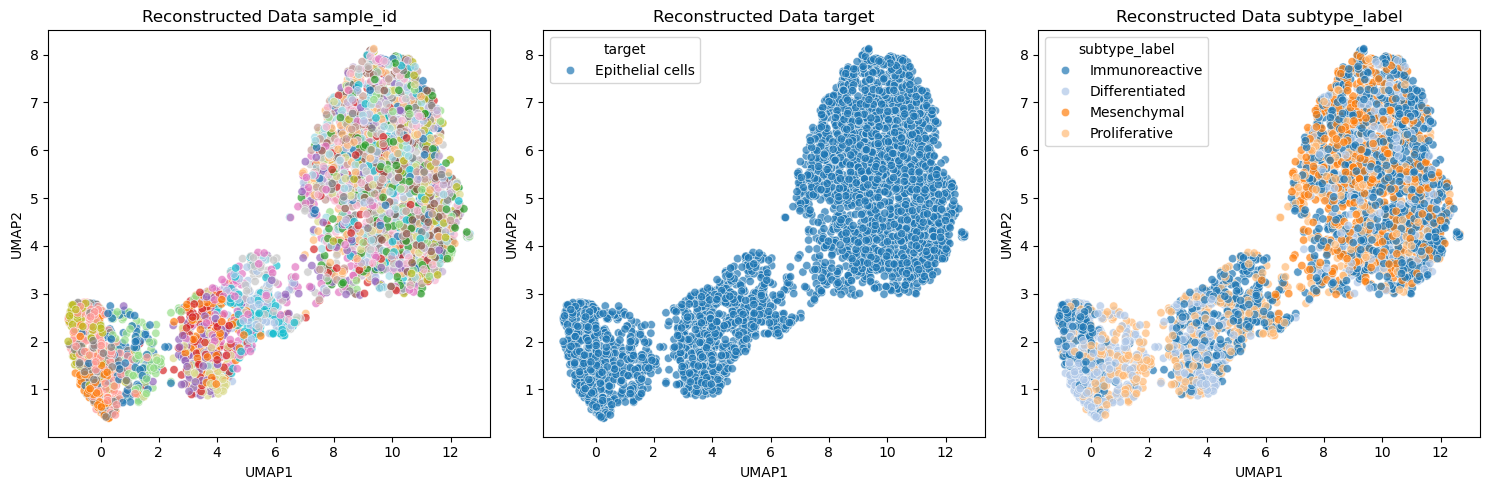

In [18]:
select_idx = np.where(ct_perturb_meta['target'] == select_ct)[0]
plot_reconstruction(
    x_reconstruct=x_reconst_ct_perturb[select_idx],
    meta_reconstruct=ct_perturb_meta.iloc[select_idx],
    reduction_method='UMAP',
    color_by=[SAMPLE_ID_COL, 'target', 'subtype_label'],
    palette='tab20',
)

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


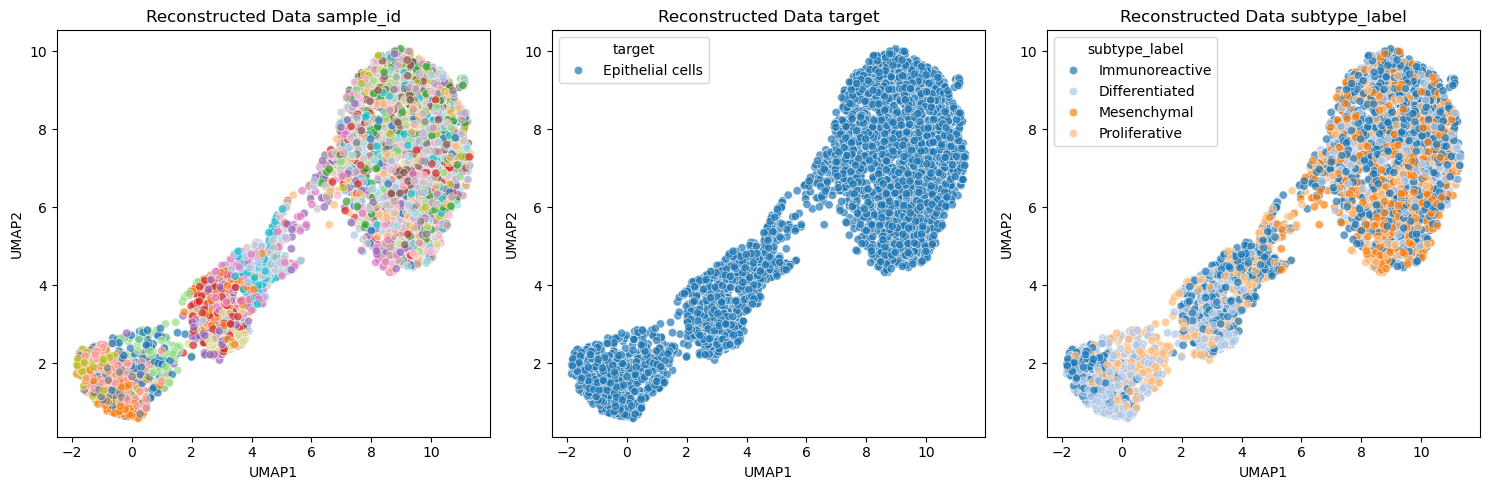

In [19]:
select_idx = np.where(ct_perturb_meta['target'] == select_ct)[0]

plot_reconstruction(
    x_reconstruct=x_reconst_ct_perturb[select_idx],
    meta_reconstruct=ct_perturb_meta.iloc[select_idx],
    reduction_method='UMAP',
    color_by=[SAMPLE_ID_COL, 'target', 'subtype_label'],
    palette='tab20',
)

## Integrate over Slack

In [20]:
x_reconst_ct_perturb, ct_perturb_meta = _impute_sc_expression(
    obj=obj,
    X=X,
    meta=meta,
    cell_type_names=buddi4_data.cell_type_names,
    cell_type_col=buddi4_data.ct_column,
    n_subsamples=None,
    n_resamples=100,
    integrate_over=['slack'],
    ignore_cell_types=[ct for ct in buddi4_data.cell_type_names if ct not in select_ct],
    seed=42
)

Imputing single cell types:   0%|          | 0/1 [00:00<?, ?it/s]

Imputing single cell types: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


In [21]:
ct_perturb_meta = pd.merge(
    ct_perturb_meta, 
    bulk_metadata_df, 
    left_on=SAMPLE_ID_COL, 
    right_on=SAMPLE_ID_COL, 
    how='left')

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


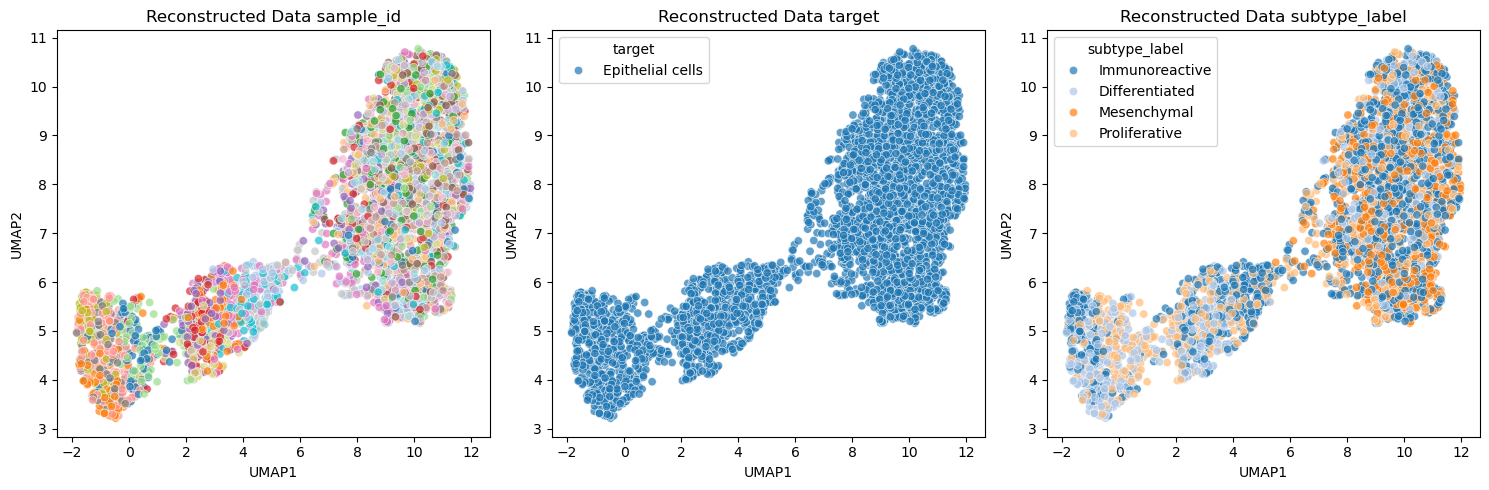

In [22]:
select_idx = np.where(ct_perturb_meta['target'] == select_ct)[0]
plot_reconstruction(
    x_reconstruct=x_reconst_ct_perturb[select_idx],
    meta_reconstruct=ct_perturb_meta.iloc[select_idx],
    reduction_method='UMAP',
    color_by=[SAMPLE_ID_COL, 'target', 'subtype_label'],
    palette='tab20',
)

### Visualize alongside proportions

In [23]:
buddi4_data.cell_type_names

['Adipocytes',
 'B-cells',
 'CD4+ T-cells',
 'CD8+ T-cells',
 'Endothelial cells',
 'Epithelial cells',
 'Fibroblasts',
 'Macrophages',
 'Mesangial cells',
 'Monocytes',
 'NK cells']

In [ ]:
with tf.device('/CPU:0'):
    y_hat = obj.prop_estimator(
        X
    ).numpy()
y_hat_df = pd.DataFrame(
    y_hat,
    columns=buddi4_data.cell_type_names,
    index=meta[SAMPLE_ID_COL]
)

# prevent multiple merge attempts
if not all([col in ct_perturb_meta.columns for col in y_hat_df.columns]):
    ct_perturb_meta = pd.merge(
        ct_perturb_meta, 
        y_hat_df, 
        left_on=SAMPLE_ID_COL, 
        right_on=SAMPLE_ID_COL, 
        how='left'
    )

select_idx = np.where(ct_perturb_meta['target'] == select_ct)[0]

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


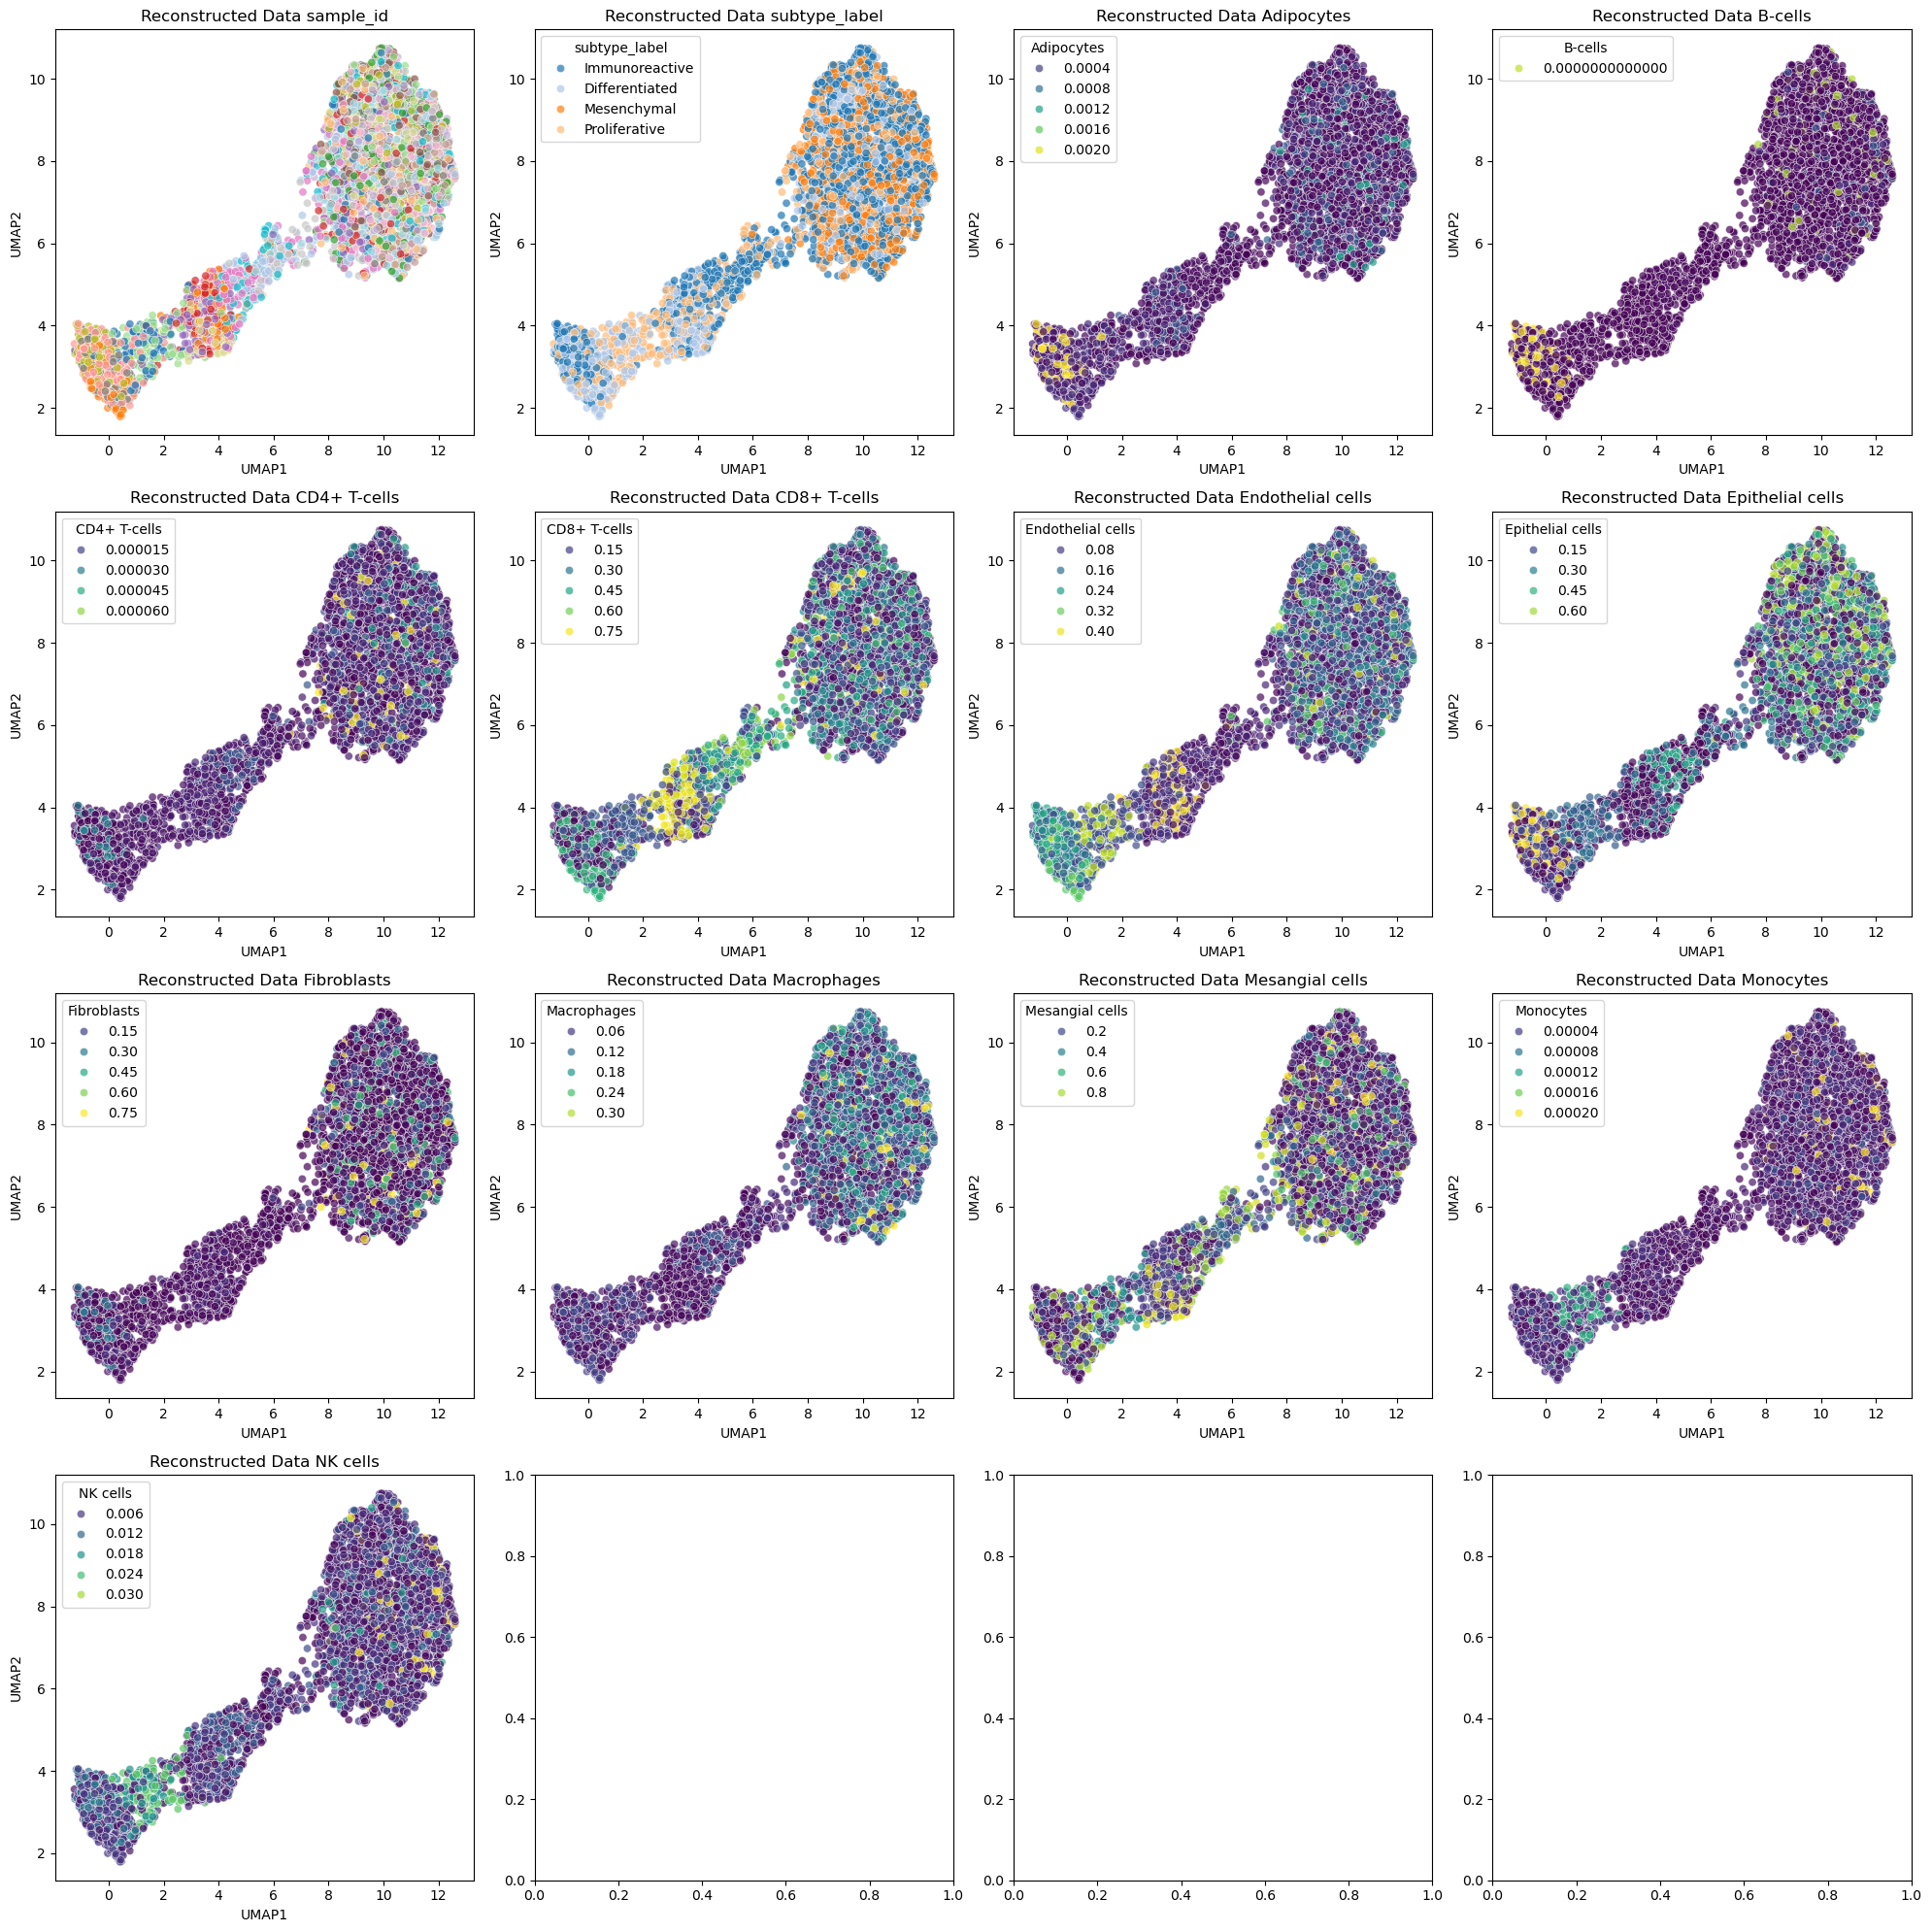

In [25]:
plot_reconstruction(
    x_reconstruct=x_reconst_ct_perturb[select_idx],
    meta_reconstruct=ct_perturb_meta.iloc[select_idx],
    reduction_method='UMAP',
    color_by=[SAMPLE_ID_COL, 'subtype_label'] + buddi4_data.cell_type_names,
    palette='tab20',
    ncols=4
)